In [1]:
import numpy as np
import time
import matplotlib.pyplot as plt

import lasagne
import theano
import theano.tensor as T
import numpy as np
from lasagne.layers import DenseLayer,\
                           Conv2DLayer,\
                           MaxPool2DLayer,\
                           InputLayer,\
                           GlobalPoolLayer,\
                           DropoutLayer,\
                           Upscale2DLayer
from lasagne.nonlinearities import elu, sigmoid, rectify

plt.style.use('ggplot')

%matplotlib inline

In [2]:
noise = np.load('../../The-Quest-For-Mu/noise200_200.npy')

In [3]:
artificial_tracks = np.load('../../The-Quest-For-Mu/convolves2.npy')

In [4]:
def gen_big_pictures_dataset(tracks, noise, size, tracks_count, shape=(200, 200)):
    assert(len(shape) == 2)
    assert(shape[0] == shape[1])
    
    dataset = []
    targets = []
    
    past_time = time.time()
    for j in xrange(size):
        if j % 100 == 0:
            print(j, time.time() - past_time)
            past_time = time.time()
            
        template = np.zeros(shape)
        answer = np.zeros(shape)
        noise_template = noise[np.random.choice(np.arange(noise.shape[0]))].reshape(200, 200)
        signal_samples = artificial_tracks[np.random.choice(np.arange(artificial_tracks.shape[0]),
                                                            replace=False,
                                                            size=tracks_count)]
        
        if tracks_count > 0:
            tlx = np.random.choice(np.arange(shape[0] - signal_samples[0].shape[0]), replace=False, size=tracks_count)
            tly = np.random.choice(np.arange(shape[1] - signal_samples[0].shape[1]), replace=False, size=tracks_count)
        
        for i in xrange(tracks_count):
            answer[tlx[i]:tlx[i] + signal_samples[0].shape[0],\
                   tly[i]:tly[i] + signal_samples[0].shape[1]] = (signal_samples[i] > 0).astype(np.int8)
            template[tlx[i]:tlx[i] + signal_samples[0].shape[0],\
                     tly[i]:tly[i] + signal_samples[0].shape[1]] = signal_samples[i]
                
        
        sample = np.max([5 * template / (1e-6 + template.max() - template.min()),
                         6 * noise_template / (1e-6 + noise_template.max() - noise_template.min())],
                        axis=0)
        
        dataset.append(sample.ravel())
        targets.append(answer.ravel())
                
    return np.vstack(dataset), np.vstack(targets)

In [5]:
dataset, targets = gen_big_pictures_dataset(artificial_tracks, noise, 10000, 3)

(0, 2.86102294921875e-06)
(100, 0.3016500473022461)
(200, 0.30141401290893555)
(300, 0.30114197731018066)
(400, 0.30068302154541016)
(500, 0.2955050468444824)
(600, 0.30235791206359863)
(700, 0.30146312713623047)
(800, 0.2953300476074219)
(900, 0.2955191135406494)
(1000, 0.32473087310791016)
(1100, 0.32064390182495117)
(1200, 0.32387709617614746)
(1300, 0.32346010208129883)
(1400, 0.32189393043518066)
(1500, 0.32449889183044434)
(1600, 0.32418107986450195)
(1700, 0.3214409351348877)
(1800, 0.3235931396484375)
(1900, 0.32305192947387695)
(2000, 0.3207390308380127)
(2100, 0.31801700592041016)
(2200, 0.3218810558319092)
(2300, 0.3215758800506592)
(2400, 0.3201169967651367)
(2500, 0.31856513023376465)
(2600, 0.32099294662475586)
(2700, 0.31680798530578613)
(2800, 0.322070837020874)
(2900, 0.32507896423339844)
(3000, 0.3179900646209717)
(3100, 0.3219921588897705)
(3200, 0.32346510887145996)
(3300, 0.31648707389831543)
(3400, 0.32149386405944824)
(3500, 0.3211400508880615)
(3600, 0.318809032

In [6]:
def iterate_minibatches(inputs, targets, batch_size):
    indices = np.arange(len(inputs))
    np.random.shuffle(indices)
    
    for start_idx in range(0, len(inputs) - batch_size + 1, batch_size):
        excerpt = indices[start_idx:start_idx + batch_size]

        yield inputs[excerpt], targets[excerpt]

In [7]:
def downscale(targets, window=20):
    new_shape = targets[0].shape[-1] / window
    results = np.zeros((0, new_shape, new_shape))
    
    for target in targets:
        result = np.zeros((new_shape, new_shape))
        for xs in range(new_shape):
            for ys in range(new_shape):
                result[xs, ys] = target[xs * window:(xs + 1) * window, ys * window:(ys + 1) * window].max()
                
        results = np.vstack((results, result.reshape(1, new_shape, new_shape)))
                
    return results

In [8]:
downsampled_answers = downscale(targets.reshape(-1, 200, 200))

In [9]:
from sklearn.cross_validation import train_test_split

X_y = train_test_split(dataset.reshape(-1, 1, 200, 200).astype(np.float32),
                       downsampled_answers.reshape(-1, 1, 10, 10).astype(np.float32))

In [37]:
def learn(nn, dataset, num_epochs=100, batch_size=50):
    '''
        num_epochs - amount of passes through the data
        batch_size - number of samples processed at each function call
        dataset - [X_train, X_val, y_train, y_val]
    '''
    
    X_train, X_val, y_train, y_val = dataset

    for epoch in range(num_epochs):
        # In each epoch, we do a full pass over the training data:
        train_err = 0
        train_acc = 0
        train_batches = 0
        train_pos_error = 0
        start_time = time.time()

        for batch in iterate_minibatches(X_train, y_train, batch_size):
            inputs, targets = batch
            train_err_batch, train_pos_error_batch, train_acc_batch = nn.train(inputs, targets)
            train_err += train_err_batch
            train_acc += train_acc_batch
            train_pos_error += train_pos_error_batch
            train_batches += 1

        # And a full pass over the validation data:
        val_acc = 0
        val_batches = 0
        val_pos_error = 0

        for batch in iterate_minibatches(X_val, y_val, batch_size):
            inputs, targets = batch
            val_pos_error_batch, val_acc_batch = nn.evaluate(inputs, targets)
            val_acc += val_acc_batch
            val_pos_error += val_pos_error_batch
            val_batches += 1

        # Then we print the results for this epoch:
        print('Epoch {} of {} took {:.3f}s'.format(epoch + 1, num_epochs, time.time() - start_time))
        print('  training loss (in-iteration):\t\t\t{:.6f}'.format(train_err / train_batches))
        print('  train accuracy:\t\t{:.2f} %'.format(train_acc / train_batches * 100))
        print('  train recall:\t\t\t{:.2f} %'.format(train_pos_error / train_batches * 100))
        print('  validation accuracy:\t\t{:.2f} %'.format(val_acc / val_batches * 100))
        print('  validation recall:\t\t{:.2f} %'.format(val_pos_error / val_batches * 100))

In [58]:
class Base():
    def __init__(self, img_shape=(200, 200), learning_rate=1e-2, c=1.0):
        self.c = c
        self.input_X = T.tensor4('inputs')
        self.targets = T.tensor4('targets')
        self.output_layer = self.build_network(img_shape)
        self.output = lasagne.layers.get_output(self.output_layer, self.input_X)
        self.train = self.compile_trainer(learning_rate)
        self.evaluate = self.compile_evaluator()
        self.predict = self.compile_forward_pass()

    # TODO: could be modified
    #   add cost as sum nonzeros elements in the middle layers
    def get_obj(self):             
        a = self.output.ravel()
        t = self.targets.ravel()

        return -(t * T.log(a) + self.c * (1.0 - t) * T.log(1.0 - a)).mean()
    
    def get_recall(self):   
        a = self.output.ravel()
        t = self.targets.ravel()
        
        return ((a > 0.5) * t).sum() / t.sum()
    
    def get_accuracy(self):                      
        return lasagne.objectives.binary_accuracy(self.output, self.targets).mean()

    # TODO: could be modified
    def compile_trainer(self, learning_rate):
        obj = self.get_obj()
        params = lasagne.layers.get_all_params(self.output_layer, trainable=True)
        updates = lasagne.updates.adagrad(obj, params, learning_rate=learning_rate)
        
        return theano.function([self.input_X, self.targets], 
                               [obj,
                                self.get_recall(),
                                self.get_accuracy()],
                               updates=updates)

    # TODO: could be modified
    def build_network(self, img_shape):
        input_layer = InputLayer((None, 1) + tuple(img_shape), self.input_X)

        conv0 = Conv2DLayer(input_layer, num_filters=3, filter_size = 3, pad='same', nonlinearity=elu)
        mp01 = MaxPool2DLayer(conv0, pool_size=5)
        conv1 = Conv2DLayer(mp01, num_filters=6, filter_size = 3, pad='same', nonlinearity=elu)
        mp12 = MaxPool2DLayer(conv1, pool_size=4)
        out = Conv2DLayer(mp12, num_filters = 1, filter_size = 1, pad='same', nonlinearity=sigmoid)

        return out

    # TODO: could be modified
    def compile_forward_pass(self):
        return theano.function([self.input_X], self.output)

    def compile_evaluator(self):        
        return theano.function([self.input_X, self.targets], [self.get_recall(), self.get_accuracy()])

In [62]:
base = Base(c=1e-1, learning_rate=1e-3)

In [63]:
learn(base, X_y, num_epochs=100, batch_size=50)

Epoch 1 of 100 took 3.788s
  training loss (in-iteration):			0.099827
  train accuracy:		54.73 %
  train recall:			98.69 %
  validation accuracy:		59.31 %
  validation recall:		98.73 %
Epoch 2 of 100 took 3.599s
  training loss (in-iteration):			0.090452
  train accuracy:		63.10 %
  train recall:			98.60 %
  validation accuracy:		66.61 %
  validation recall:		98.55 %
Epoch 3 of 100 took 3.472s
  training loss (in-iteration):			0.084696
  train accuracy:		69.59 %
  train recall:			98.40 %
  validation accuracy:		72.49 %
  validation recall:		98.30 %
Epoch 4 of 100 took 3.570s
  training loss (in-iteration):			0.080185
  train accuracy:		74.89 %
  train recall:			98.22 %
  validation accuracy:		77.01 %
  validation recall:		98.11 %
Epoch 5 of 100 took 3.225s
  training loss (in-iteration):			0.076433
  train accuracy:		78.80 %
  train recall:			98.05 %
  validation accuracy:		80.63 %
  validation recall:		97.92 %
Epoch 6 of 100 took 3.677s
  training loss (in-iteration):			0.073235
  tra

KeyboardInterrupt: 

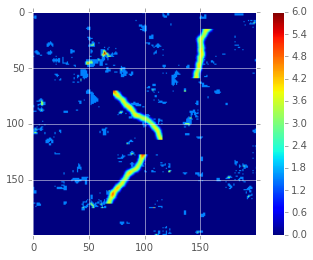

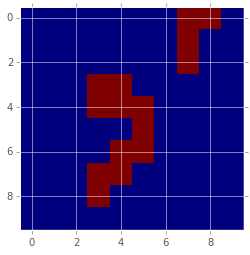

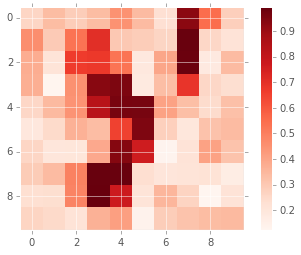

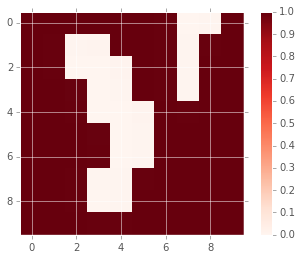

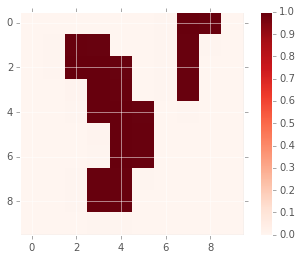

In [65]:
i = 2

plt.imshow(X_y[1][i].reshape((200, 200)))
plt.colorbar()
plt.show()

plt.imshow(X_y[-1][i].reshape((10, 10)), interpolation='none')
plt.show()

prediction = base.predict(X_y[1][i].reshape((1, 1, 200, 200)).astype(np.float32))

plt.imshow(prediction.reshape(10, 10), interpolation='none', cmap=plt.cm.Reds)
plt.colorbar()
plt.show()

plt.imshow(prediction.reshape(10, 10) < 0.5, interpolation='none', cmap=plt.cm.Reds)
plt.colorbar()
plt.show()

plt.imshow(prediction.reshape(10, 10) >= 0.5, interpolation='none', cmap=plt.cm.Reds)
plt.colorbar()
plt.show()